In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
from bayes_opt import BayesianOptimization

In [2]:
# SPDR ETFs
assets = [
    'XLC',  # Communication Services
    'XLY',  # Consumer Discretionary
    'XLP',  # Consumer Staples
    'XLE',  # Energy
    'XLF',  # Financials
    'XLV',  # Health Care
    'XLI',  # Industrials
    'XLB',  # Materials
    'XLRE', # Real Estate
    'XLK',  # Technology
    'XLU',  # Utilities
    'SPY',  # S&P 500
]

# Download data from Yahoo Finance since 2018-06-19 (when all ETFs are available)
start = '2018-06-19'
data = {}
for ticker in assets:
    data[ticker] = yf.download(ticker, start=start)

# Calculate daily returns
returns = pd.DataFrame()
for ticker in assets:
    returns[ticker] = data[ticker]['Adj Close'].pct_change().iloc[1:]
returns.index = data['SPY'].iloc[1:].index

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
def MA_strategy(asset_returns, lower_period, upper_period):
    '''
    asset_returns: dataframe with the returns of a single asset
    lower_period: lower moving average period
    upper_period: upper moving average period

    Returns the strategy's performance
    '''
    num_periods = len(asset_returns)
    weights = []
    for i in range(upper_period, num_periods):
        lower_ma = (asset_returns.iloc[i-lower_period:i]+1).cumprod().iloc[0]
        upper_ma = (asset_returns.iloc[i-upper_period:i]+1).cumprod().iloc[0]
        diff = lower_ma - upper_ma
        if diff > 0:
            weights.append(1)
        else:
            weights.append(0)
    result = asset_returns[upper_period:].copy()
    result['Weight'] = weights
    result['Return'] = result['Weight'] * asset_returns[upper_period:]
    mean = result['Return'].mean() * 252
    std = result['Return'].std() * np.sqrt(252)
    sharpe = mean/std
    return result, mean, std, sharpe

In [4]:
# Perform Bayesian optimization
def MA_objective(lower_period, upper_period):
    lower_period = int(lower_period)
    upper_period = int(upper_period)
    if upper_period <= lower_period:
        return -1
    sharpe = MA_strategy(returns['SPY'], lower_period, upper_period)[3]
    return sharpe

pbounds = {
    'lower_period': (1, 100),
    'upper_period': (50, 250)
}

optimizer = BayesianOptimization(MA_objective, pbounds)
optimizer.maximize(init_points=20, n_iter=100)
print(optimizer.max)

|   iter    |  target   | lower_... | upper_... |
-------------------------------------------------
| 1         | 0.1219    | 69.43     | 88.58     |
| 2         | 0.1075    | 38.45     | 203.4     |
| 3         | 0.2075    | 20.77     | 63.54     |
| 4         | -0.06345  | 48.23     | 97.73     |
| 5         | 0.3244    | 45.62     | 247.8     |
| 6         | 0.8197    | 87.12     | 229.7     |
| 7         | 1.139     | 5.262     | 181.5     |
| 8         | 0.5681    | 29.7      | 249.3     |
| 9         | 0.5526    | 65.18     | 212.0     |
| 10        | 0.1309    | 39.49     | 149.9     |
| 11        | -0.1802   | 94.64     | 219.8     |
| 12        | 0.2678    | 68.96     | 135.1     |
| 13        | 0.8423    | 11.46     | 86.5      |
| 14        | 0.6302    | 97.2      | 131.9     |
| 15        | -1.0      | 67.87     | 58.25     |
| 16        | 0.5303    | 29.5      | 220.4     |
| 17        | 0.3543    | 32.91     | 209.5     |
| 18        | 0.8218    | 2.826     | 56.97     |


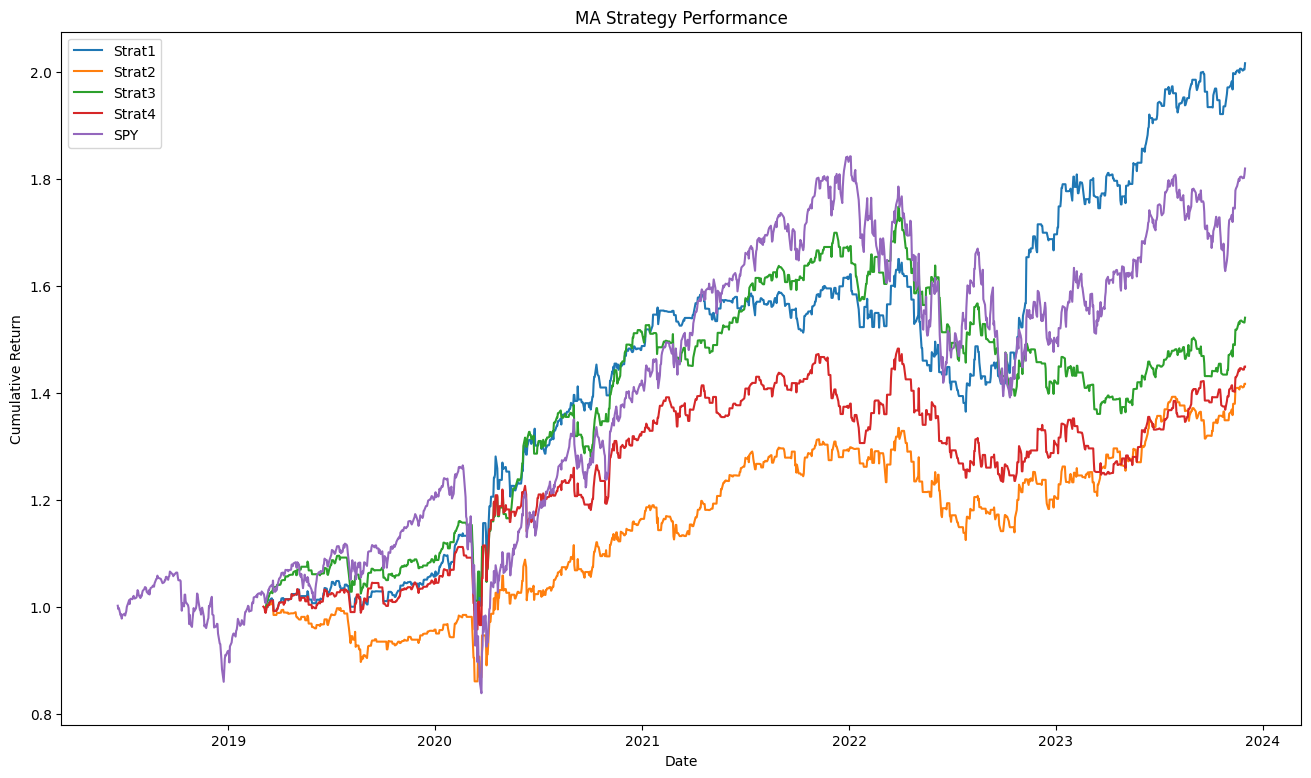

In [6]:
strat1 = MA_strategy(returns['SPY'], 5, 181)[0]
strat2 = MA_strategy(returns['SPY'], 5, 180)[0]
strat3 = MA_strategy(returns['SPY'], 5, 179)[0]
strat4 = MA_strategy(returns['SPY'], 5, 175)[0]

# Plot strategy's performances
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((strat1['Return']+1).cumprod(), label='Strat1')
ax.plot((strat2['Return']+1).cumprod(), label='Strat2')
ax.plot((strat3['Return']+1).cumprod(), label='Strat3')
ax.plot((strat4['Return']+1).cumprod(), label='Strat4')
ax.plot((returns['SPY']+1).cumprod(), label='SPY')
ax.legend()
ax.set_title('MA Strategy Performance')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
plt.show()